In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [47]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [48]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [49]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:56:46 - cmdstanpy - INFO - Chain [1] start processing
02:56:47 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [51]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2642,2023-12-30,12.540607,10.124874,14.968572
2643,2023-12-31,12.532905,9.995045,14.919615
2644,2024-01-01,11.728708,9.459149,14.199913
2645,2024-01-02,11.725691,9.329254,14.070589
2646,2024-01-03,11.764198,9.214349,14.092207


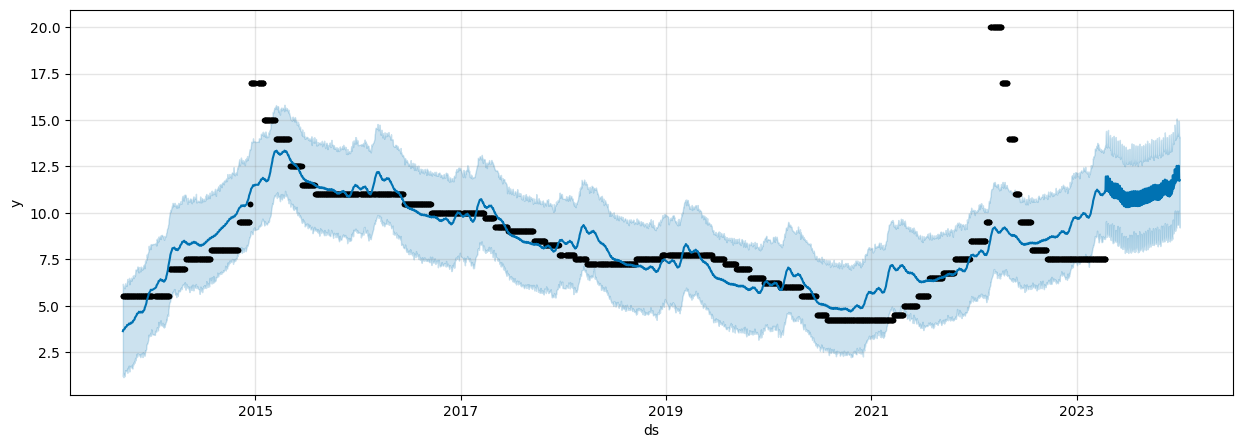

In [52]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

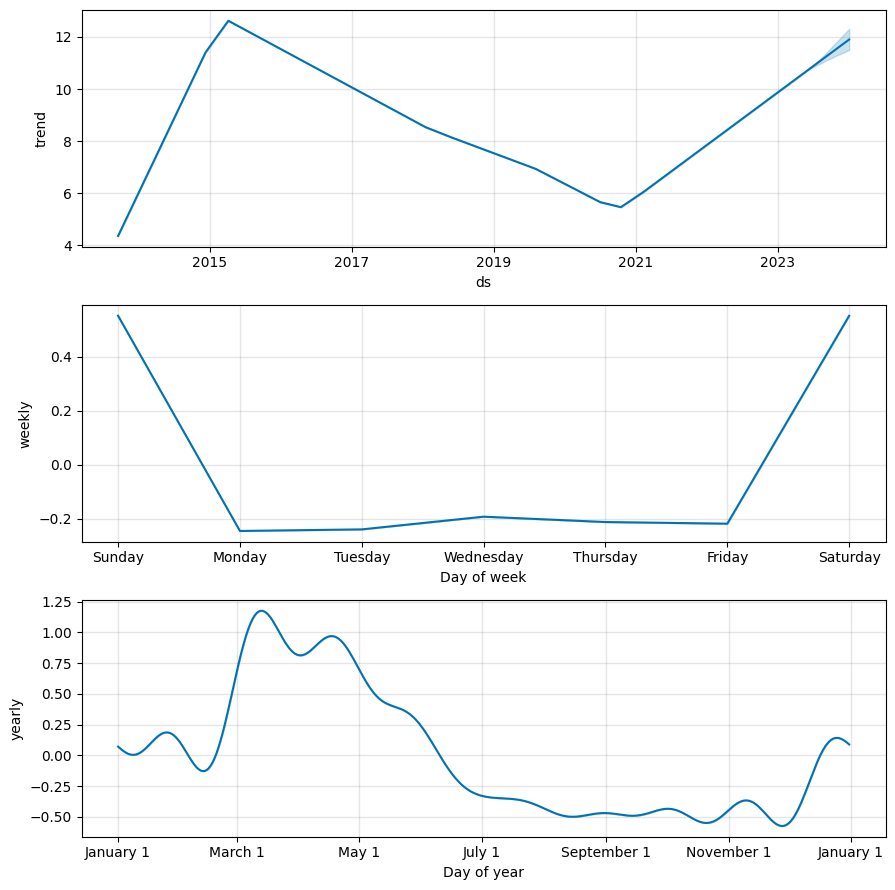

In [53]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [54]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-23,13.187236,10.756860,15.746174
260,2024-04-24,13.218557,10.657439,15.802999
261,2024-04-25,13.180564,10.683896,15.628064
262,2024-04-26,13.154025,10.655402,15.694897
263,2024-04-29,13.057132,10.593051,15.749115


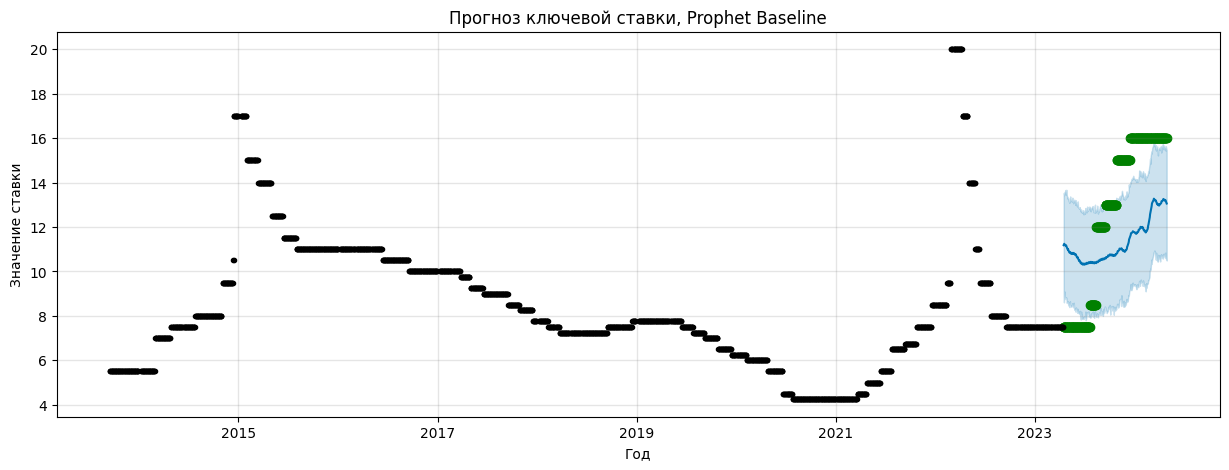

In [55]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

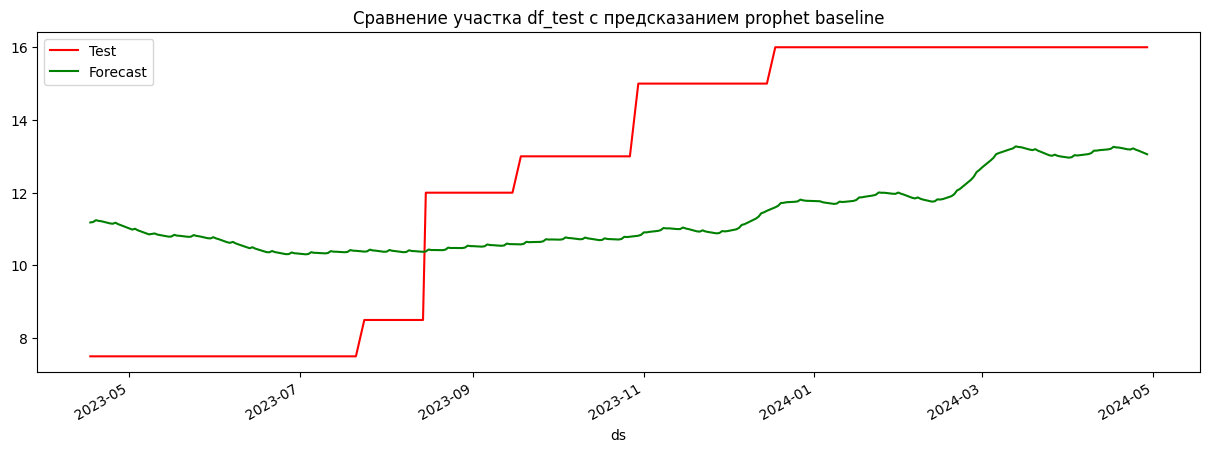

In [56]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [57]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.083517,0.264786,10.248278,3.201293


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [58]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [59]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:56:51 - cmdstanpy - INFO - Chain [1] start processing
02:56:51 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2642,2023-12-30,12.624006,10.479095,15.031682
2643,2023-12-31,12.622951,10.167656,15.075537
2644,2024-01-01,11.142458,8.778490,13.524239
2645,2024-01-02,11.143930,8.671339,13.657370
2646,2024-01-03,11.189804,8.698732,13.520984


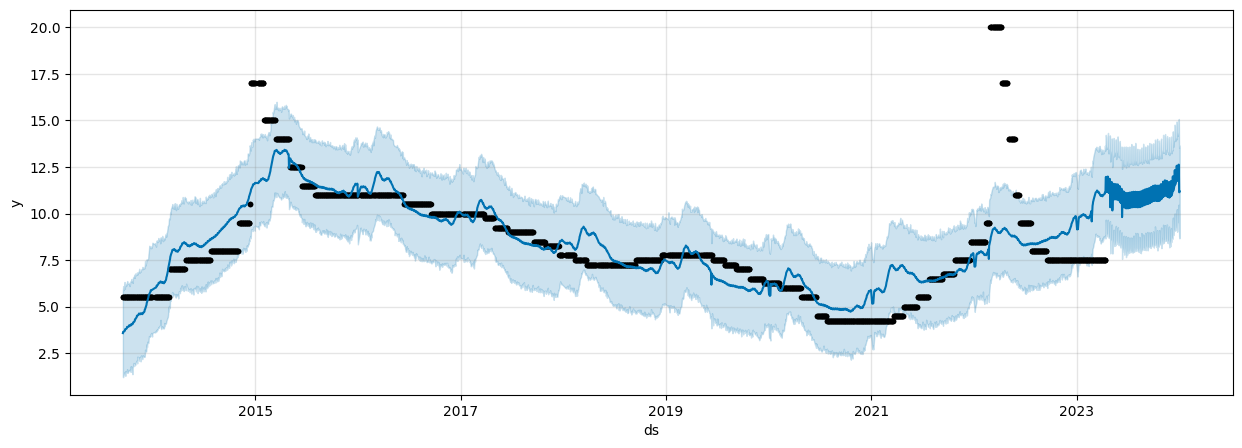

In [61]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

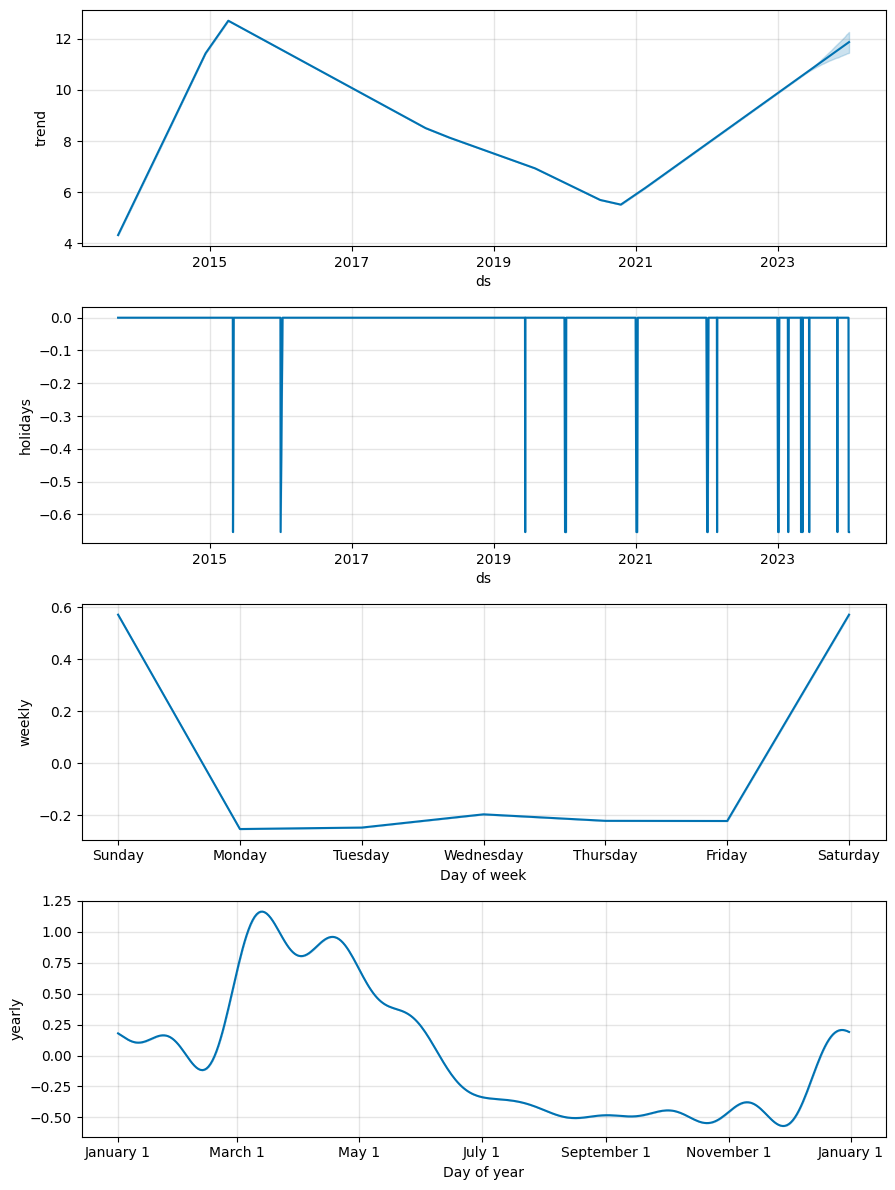

In [62]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [63]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-23,13.138237,10.722559,15.637260
260,2024-04-24,13.174423,10.717382,15.568604
261,2024-04-25,13.131996,10.549136,15.638979
262,2024-04-26,13.111602,10.426398,15.738659
263,2024-04-29,13.010886,10.511910,15.381236


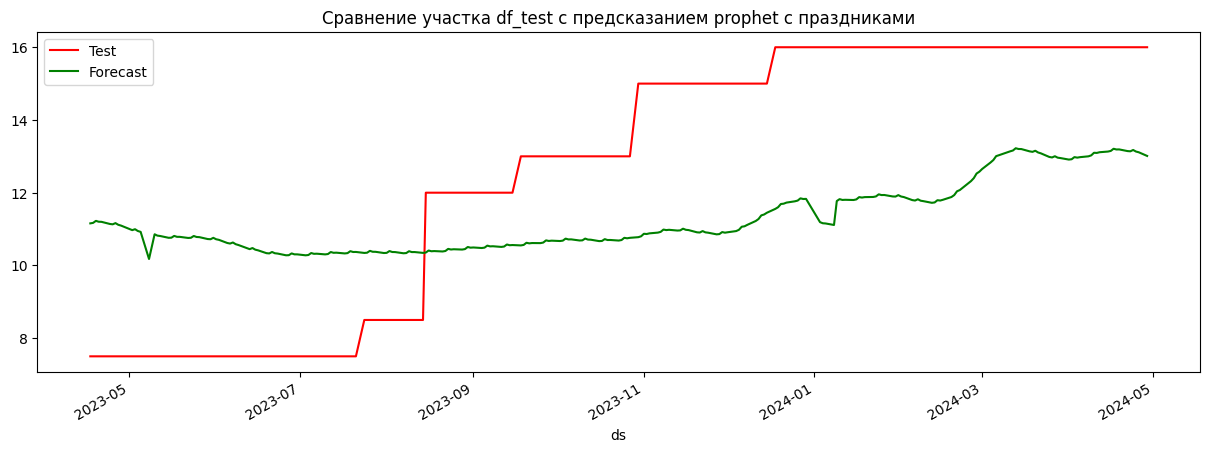

In [64]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [65]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.083517,0.264786,10.248278,3.201293
0,Prophet_with_holidays,3.105503,0.265577,10.412486,3.226838


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [66]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [67]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]02:56:55 - cmdstanpy - INFO - Chain [1] start processing
02:56:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<08:36,  1.30it/s]02:56:56 - cmdstanpy - INFO - Chain [1] start processing
02:56:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<08:34,  1.30it/s]02:56:57 - cmdstanpy - INFO - Chain [1] start processing
02:56:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:02<08:35,  1.30it/s]02:56:58 - cmdstanpy - INFO - Chain [1] start processing
02:56:58 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:03<08:56,  1.24it/s]02:56:58 - cmdstanpy - INFO - Chain [1] start processing
02:56:59 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:03<08:39,  1.28it/s]02:56:59 - cmdstanpy - INFO - Chain [1] start processing
02:56:59 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:04<08:36,  1.29it/s]0

In [68]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [69]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.688922,0.389293,46.683515,6.832534,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.871735,0.403755,49.283100,7.020192,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.853077,0.402343,49.001790,7.000128,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.851867,0.401993,49.033231,7.002373,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.618504,0.384850,45.516357,6.746581,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.932035,1.044668,309.273287,17.586167,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.307580,0.330674,22.237590,4.715675,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.387986,0.336717,23.089665,4.805171,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.400990,0.336443,23.350874,4.832274,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [70]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.608129,0.305111,14.438011,3.799738,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.608129,0.305111,14.438011,3.799738,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.608129,0.305111,14.438011,3.799738,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.608129,0.305111,14.438011,3.799738,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.619347,0.305650,14.511659,3.809417,"{'changepoint_prior_scale': 0.06, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [71]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [72]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

03:19:02 - cmdstanpy - INFO - Chain [1] start processing
03:19:03 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2642,2023-12-30,12.540607,10.138574,15.103235
2643,2023-12-31,12.532905,10.176603,15.009915
2644,2024-01-01,11.728708,9.274677,14.114876
2645,2024-01-02,11.725691,9.099436,14.091486
2646,2024-01-03,11.764198,9.498007,14.168941


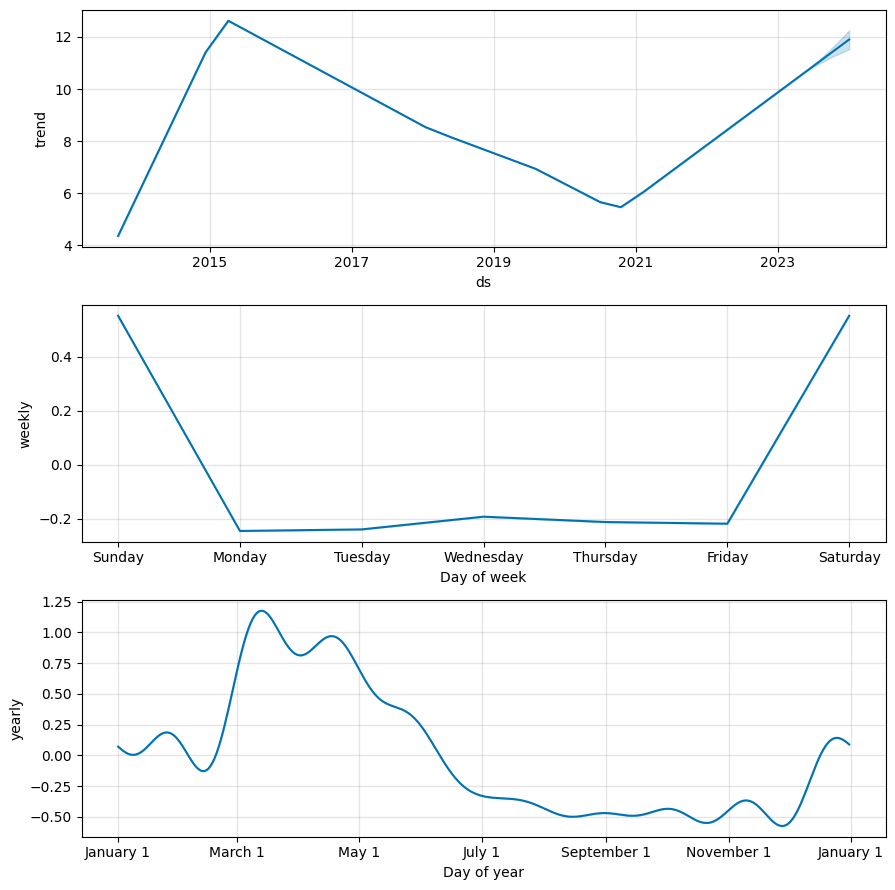

In [74]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

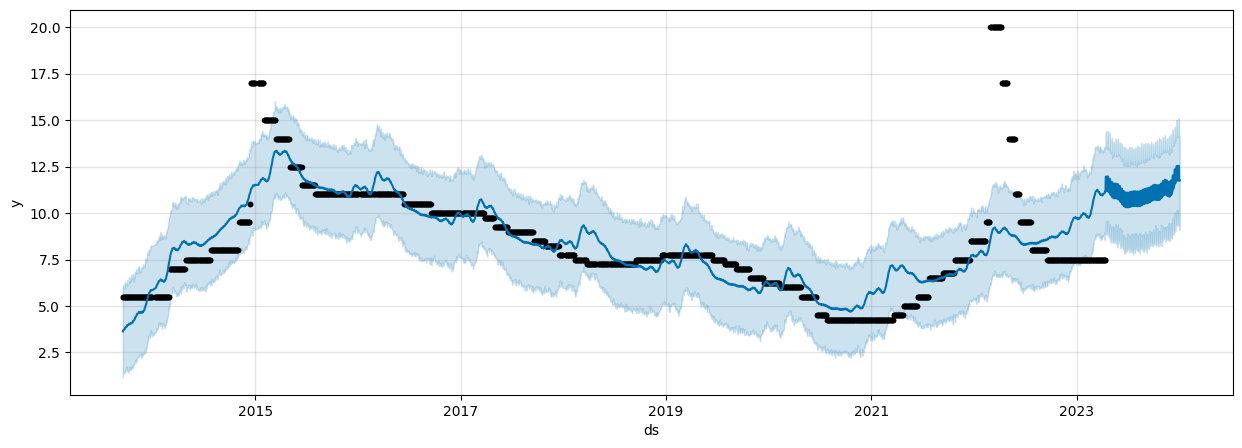

In [75]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [76]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
259,2024-04-23,13.187236,10.867514,15.651310
260,2024-04-24,13.218557,10.763432,15.732025
261,2024-04-25,13.180564,10.831094,15.738128
262,2024-04-26,13.154025,10.580479,15.619680
263,2024-04-29,13.057132,10.586056,15.578500


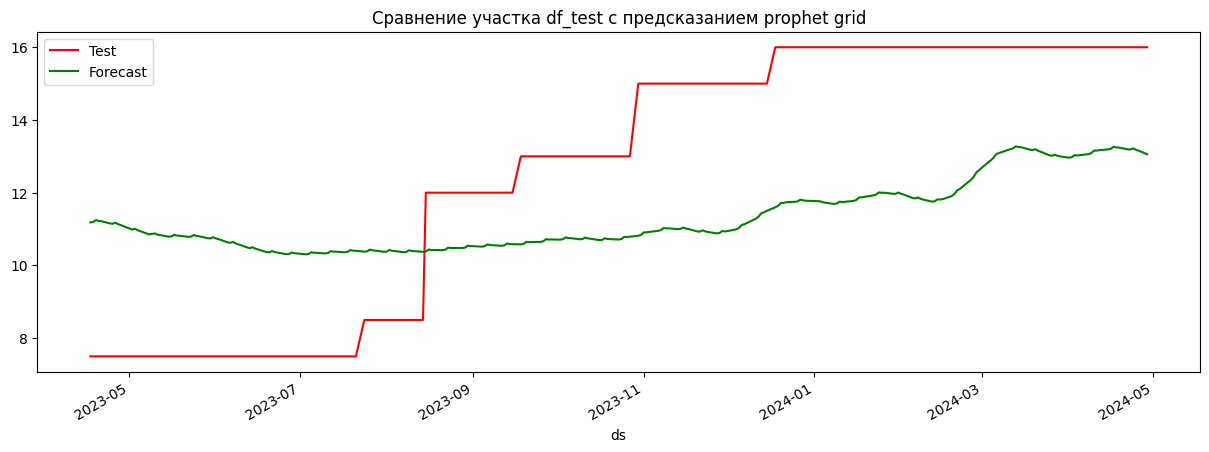

In [77]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [78]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.083517,0.264786,10.248278,3.201293
0,Prophet_with_holidays,3.105503,0.265577,10.412486,3.226838
0,Prophet_with_grid,3.083517,0.264786,10.248278,3.201293


In [79]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))